<a href="https://colab.research.google.com/github/zdanielshi/data_science_LFZ/blob/main/Kaggle_Space_Titanic_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# classifiers

pd.options.display.float_format = '{:,.3f}'.format

In [ ]:
# mounting Google Drive and loading files
from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Colab data/train space titanic.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Colab data/test space titanic.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Analysis

In [ ]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000,True,43.000,"3,576.000",0.000,"6,715.000",49.000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000,False,0.000,"1,283.000",371.000,"3,329.000",193.000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.000,True,0.000,"6,819.000",0.000,"1,643.000",74.000,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.000,False,0.000,0.000,0.000,0.000,0.000,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.000,False,0.000,0.000,"1,872.000",1.000,0.000,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.000,False,0.000,"1,049.000",0.000,353.000,"3,235.000",Celeon Hontichre,False


In [ ]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

#Stacking and separating the testing and training data

In [ ]:
train['train_data'] = True
test['train_data'] = False

In [ ]:
x = train.loc[:,train.columns != 'Transported'].copy()
transported = train.loc[:,train.columns == 'Transported'].copy()

In [ ]:
x = pd.concat([x, test], axis = 0)

In [ ]:
x.isnull().sum()

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
train_data        0
dtype: int64

## Ad hoc feature engineering: splitting up passenger ID and cabin columns

In [ ]:
# Splitting up Passenger Id into Group and GroupSubId within group
x[['GroupId', 'GroupSubId']] = x['PassengerId'].str.split('_', expand = True)

In [ ]:
x[['Deck', 'Number', 'Side']] = x['Cabin'].str.split('/', expand = True)

In [ ]:
x

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,train_data,GroupId,GroupSubId,Deck,Number,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,True,0001,01,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,Juanna Vines,True,0002,01,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000,True,43.000,"3,576.000",0.000,"6,715.000",49.000,Altark Susent,True,0003,01,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000,False,0.000,"1,283.000",371.000,"3,329.000",193.000,Solam Susent,True,0003,02,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,Willy Santantines,True,0004,01,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000,False,0.000,0.000,0.000,0.000,0.000,Jeron Peter,False,9266,02,G,1496,S
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.000,False,0.000,847.000,17.000,10.000,144.000,Matty Scheron,False,9269,01,NaN,NaN,NaN
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.000,0.000,0.000,0.000,0.000,Jayrin Pore,False,9271,01,D,296,P
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.000,"2,680.000",0.000,0.000,523.000,Kitakan Conale,False,9273,01,D,297,P


# Clean up

## Filling in nulls
Ideas
* Same ID group, would have the same Cabin and home planet

In [ ]:
x.groupby('Destination')['HomePlanet'].value_counts(normalize=True)

Destination    HomePlanet
55 Cancri e    Europa       0.506
               Earth        0.380
               Mars         0.114
PSO J318.5-22  Earth        0.917
               Mars         0.058
               Europa       0.025
TRAPPIST-1e    Earth        0.539
               Mars         0.260
               Europa       0.200
Name: HomePlanet, dtype: float64

In [ ]:
# Fill Home Planet nulls: 55 Chancri is Europa, Earth for others
x.HomePlanet.fillna(x.Destination, inplace=True)

In [ ]:
x.HomePlanet.value_counts()

Earth            6865
Europa           3133
Mars             2684
TRAPPIST-1e       206
55 Cancri e        53
PSO J318.5-22      23
Name: HomePlanet, dtype: int64

In [ ]:
x.HomePlanet.isnull().sum()

6

In [ ]:
x.HomePlanet = x['HomePlanet'].apply(lambda x: 'Europa' if x == '55 Cancri e' else ('Earth' if x == 'PSO J318.5-22' else ('Earth' if x == 'TRAPPIST-1e' else x)))

In [ ]:
x.HomePlanet.value_counts()

Earth     7094
Europa    3186
Mars      2684
Name: HomePlanet, dtype: int64

In [ ]:
x.HomePlanet.fillna('Earth',inplace=True)

In [ ]:
x.CryoSleep.value_counts()

False    8079
True     4581
Name: CryoSleep, dtype: int64

In [ ]:
x.CryoSleep.isna().sum()

310

In [ ]:
x.CryoSleep.fillna(x.CryoSleep.mode()[0], inplace=True)

In [ ]:
# Drop cabin, and then fill in the modes for Deck, Number and Side
x.drop(columns = 'Cabin', inplace=True)
x.Deck.fillna(x.Deck.mode()[0], inplace=True)
x.Number.fillna(x.Number.mode()[0], inplace=True)
x.Side.fillna(x.Side.mode()[0], inplace=True)

In [ ]:
# Destination, fill with mode
x.Destination.fillna(x.Destination.mode()[0], inplace=True)

In [ ]:
# VIP fill with mode
x.VIP.fillna(x.VIP.mode()[0], inplace=True)

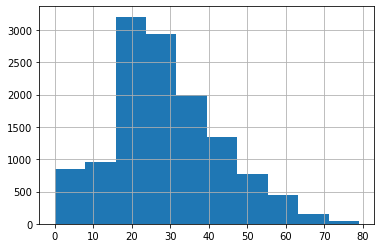

In [ ]:
x.Age.hist()

In [ ]:
x.Age.fillna(x.Age.median(), inplace=True)

In [ ]:
x.fillna(method = 'bfill', inplace=True)

# Feature Engineering
* Break up the cabin into deck, number, and side
* ID can be broken up into group and ID

In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12970 non-null  object 
 2   CryoSleep     12970 non-null  bool   
 3   Destination   12970 non-null  object 
 4   Age           12970 non-null  float64
 5   VIP           12970 non-null  bool   
 6   RoomService   12970 non-null  float64
 7   FoodCourt     12970 non-null  float64
 8   ShoppingMall  12970 non-null  float64
 9   Spa           12970 non-null  float64
 10  VRDeck        12970 non-null  float64
 11  Name          12970 non-null  object 
 12  train_data    12970 non-null  bool   
 13  GroupId       12970 non-null  object 
 14  GroupSubId    12970 non-null  object 
 15  Deck          12970 non-null  object 
 16  Number        12970 non-null  object 
 17  Side          12970 non-null  object 
dtypes: bool(3), float64(6), obj

In [ ]:
# Create a total spend colum
x['TotalSpend'] = x['RoomService'] + x['FoodCourt'] + x['ShoppingMall'] + x['ShoppingMall'] + x['Spa'] + x['VRDeck']

In [ ]:
# Boolean for if they spent ANY money
x['SpentMoney'] = x['TotalSpend']
x['SpentMoney'] = x['SpentMoney'].apply(lambda x: 1 if x > 0 else 0)
x['SpentMoney'] = x['SpentMoney'].astype('boolean')

In [ ]:
# Create a column for the travel corridor
x['TravelCorridor'] = x['HomePlanet']+" / " + x['Destination']

In [ ]:
# Create a column showing if someone is an adult at age 18
cutoff = 18
x['Adult'] = x['Age']
x['Adult'] = x['Adult'].apply(lambda x: 1 if x >= 18 else 0)
x['Adult'] = x['Adult'].astype('boolean')

In [ ]:
#group_size = x.groupby('GroupId')['GroupSubId'].max()

In [ ]:
#group_size

## Dropping some columns

In [ ]:
# drop GroupId and GroupSubId until I figure out how to utilize them
x.drop(columns = ['GroupId', 'GroupSubId'], inplace=True)

In [ ]:
# Drop Passenger Id
x.drop(columns = ['PassengerId'], inplace=True)

In [ ]:
# Drop name
x.drop(columns = ['Name'], inplace=True)

In [ ]:
# drop Number since that's the cabin number
x.drop(columns = ['Number'], inplace=True)

# Preprocessing

## Transforming

In [ ]:
x.skew()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


CryoSleep       0.614
Age             0.452
VIP             6.674
RoomService     6.092
FoodCourt       7.011
ShoppingMall   11.000
Spa             7.618
VRDeck          8.037
train_data     -0.724
TotalSpend      4.361
SpentMoney     -0.387
Adult          -1.715
dtype: float64

In [ ]:
# Transform RoomService, FoodCout, ShoppingMall, Spa, VRDeck, and TotalSpend, use YJ

x['RoomService'] = list(stats.yeojohnson(x['RoomService'])[0])
x['FoodCourt'] = list(stats.yeojohnson(x['FoodCourt'])[0])
x['ShoppingMall'] = list(stats.yeojohnson(x['ShoppingMall'])[0])
x['Spa'] = list(stats.yeojohnson(x['Spa'])[0])
x['Spa'] = list(stats.yeojohnson(x['Spa'])[0])
x['VRDeck'] = list(stats.yeojohnson(x['VRDeck'])[0])
x['TotalSpend'] = list(stats.yeojohnson(x['TotalSpend'])[0])

## Scaling

In [ ]:
num_cols_to_scale = x.select_dtypes(exclude = ['object', 'bool']).columns.values.tolist()
num_cols_to_scale

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'TotalSpend']

### Robust Scaler

In [ ]:
robust_scaler = RobustScaler().fit(x[num_cols_to_scale])
x[num_cols_to_scale] = robust_scaler.transform(x[num_cols_to_scale])

### Standard Scaler

In [ ]:
# standard_scaler = StandardScaler().fit(x[num_cols_to_scale])
# x[num_cols_to_scale] = standard_scaler.transform(x[num_cols_to_scale])

### MinMax Scaler

In [ ]:
# minmax_scaler = MinMaxScaler().fit(x[num_cols_to_scale])
# x[num_cols_to_scale] = minmax_scaler.transform(x[num_cols_to_scale])

## Encoding

In [ ]:
x = pd.get_dummies(x)

In [ ]:
x

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,train_data,TotalSpend,...,Side_S,TravelCorridor_Earth / 55 Cancri e,TravelCorridor_Earth / PSO J318.5-22,TravelCorridor_Earth / TRAPPIST-1e,TravelCorridor_Europa / 55 Cancri e,TravelCorridor_Europa / PSO J318.5-22,TravelCorridor_Europa / TRAPPIST-1e,TravelCorridor_Mars / 55 Cancri e,TravelCorridor_Mars / PSO J318.5-22,TravelCorridor_Mars / TRAPPIST-1e
0,False,0.706,False,-0.000,-0.000,-0.000,-0.000,-0.000,True,-0.857,...,0,0,0,0,0,0,1,0,0,0
1,False,-0.176,False,1.066,0.722,0.982,1.031,1.005,True,-0.005,...,1,0,0,1,0,0,0,0,0,0
2,False,1.824,True,0.987,1.176,-0.000,1.042,1.016,True,0.478,...,1,0,0,0,0,0,1,0,0,0
3,False,0.353,False,-0.000,1.150,1.175,1.040,1.118,True,0.352,...,1,0,0,0,0,0,1,0,0,0
4,False,-0.647,False,1.123,0.990,1.135,1.031,0.470,True,0.078,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,True,0.412,False,-0.000,-0.000,-0.000,-0.000,-0.000,False,-0.857,...,1,0,0,1,0,0,0,0,0,0
4273,False,0.882,False,-0.000,1.137,0.931,0.933,1.100,False,0.046,...,1,0,0,1,0,0,0,0,0,0
4274,True,0.000,False,-0.000,-0.000,-0.000,-0.000,-0.000,False,-0.857,...,0,0,0,0,0,0,0,1,0,0
4275,False,0.000,False,-0.000,1.169,-0.000,-0.000,1.162,False,0.248,...,0,0,0,0,0,0,1,0,0,0


#Training and Predicting

## Prepping the data and splitting it

In [ ]:
# Unstacking the training and test data
train = x[x.train_data == True]
test = x[x.train_data == False]

In [ ]:
train.drop(columns = 'train_data', inplace=True)
test.drop(columns = 'train_data', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train.shape, test.shape

((8693, 36), (4277, 36))

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(train, transported, test_size = .25, random_state = 7)

In [ ]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((6519, 36), (2174, 36), (6519, 1), (2174, 1))

## Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter = 100000).fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Analyzing logistic regression results

In [ ]:
lr.score(xtest, ytest)

0.7585096596136155

## KNN Classification

In [ ]:
n = 105
knn = KNeighborsClassifier(n_neighbors = n).fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### Analyzing KNN Classification results

In [ ]:
knn_score = knn.score(xtest, ytest)
knn_score

0.7552897884084636

# Predicting and uploading results

In [ ]:
to_submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Colab data/test space titanic.csv')

In [ ]:
lr_prediction = lr.predict(test)
submission = pd.DataFrame()
submission['PassengerId'] = to_submit['PassengerId']
submission['Transported'] = lr_prediction
submission.to_csv('space titanic prediction (logistic).csv', index=False)

In [ ]:
knn_prediction = knn.predict(test)
submission = pd.DataFrame()
submission['PassengerId'] = to_submit['PassengerId']
submission['Transported'] = knn_prediction
submission.to_csv('space titanic prediction (KNN).csv', index=False)